## Exploring the effect of taking a rolling mean on genetic metric trajetories

In [35]:
import numpy as np
import pandas as pd
import os

from lib.plotting import *
from lib.preferences import *
from lib.response import *

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches
import seaborn as sns

import matplotlib.gridspec as gridspec

# inline stylization
%matplotlib inline
sns.set_style("ticks")
sns.set_style('white')
#sns.set_style("ticks")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

In [37]:
# Font sizes
plt.rc('font', size=12)         # controls default text sizes
plt.rc('axes', titlesize=12)    # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

## Specify experiment

In [38]:
expt_path = "../results/2020-06-07_intv-bed"

In [39]:
sim_complete = [s for s in os.listdir(expt_path) if "Endpoint" in os.listdir(os.path.join(expt_path, s))]
n_sims = len(sim_complete)

In [40]:
print("Experiment Path: %s" % expt_path)
print("  No. Complete Simulations: %d" % n_sims)

Experiment Path: ../results/2020-06-07_intv-bed
  No. Complete Simulations: 99


## Preferences

In [41]:
savefig = True

In [42]:
analysis_metrics = ["HX", "VX"] + tight_metrics
genetic_names.update({"mean_k": "C.O.I. ($k$)",
                      "HX": "Host Prevalence",
                      "VX": "Vector Prevalence"})

In [43]:
genetic_names.update({
    "mean_k": "C.O.I ($k$)",
    "pi": "Nucl. Diversity ($\pi$)",
    "avg_l_ibd": "Avg. IBD\nTrack Length (bp)"
})

## Rolling window analysis with a single simulation

In [44]:
sim = sim_complete[1]

In [45]:
# Load full data frame
epoch_df = pd.read_csv(os.path.join(expt_path, sim, "epoch_df.csv"))
epoch_df.index = epoch_df.name
og = pd.read_csv(os.path.join(expt_path, sim, "og.csv"))
op = pd.read_csv(os.path.join(expt_path, sim, "op.csv"))

# Merge on time
ot = pd.merge(left=op, right=og, on="t0")

In [46]:
initial = subset_to_epoch(ot, epoch_df, "InitVar")

In [47]:
sizes = np.array([5, 10, 20, 60, 120, 180, 365, 365*2, 365*5, 365*10])
sizes = sizes / 5
sizes = sizes.astype("int")

In [48]:
labs = []
for size in sizes:
    if size * 5 <= 30:
        l = "%d d." % size
    elif size * 5 < 365:
        l = "%d m." % (size*5/30)
    else:
        l = "%d y." % (size*5/365)
    labs.append(l)
print(labs)

['1 d.', '2 d.', '4 d.', '2 m.', '4 m.', '6 m.', '1 y.', '2 y.', '5 y.', '10 y.']


In [49]:
dfs = []

for size in sizes:
    df = initial.rolling(size).mean().dropna()
    dfs.append(df)

### Plot results for single simulation

In [50]:
def rolling_plot(metric, sizes, dfs, cols):
    """
    Plot the effect of a rolling mean
    
    """
    
    # Normalize time to left-side of plot
    start_t0 = dfs[0]["t0"][0]
    
    # Each rolling window
    for col, df in zip(cols, dfs):
        ax.plot(df["t0"] - start_t0, df[metric], color=col)
    
    # Ticks, x-axis
    days_per_year = 365
    years_per_major_tick = 5
    ax.xaxis.set_major_locator(plt.MultipleLocator(days_per_year * years_per_major_tick))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(days_per_year))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, i : int(v / days_per_year)))
        
    
    # The mean for the metric
    ax.axhline(dfs[0][metric].mean(),
               color='darkgrey', 
               alpha=0.75,
               linewidth=4, zorder=5)
    
    return None

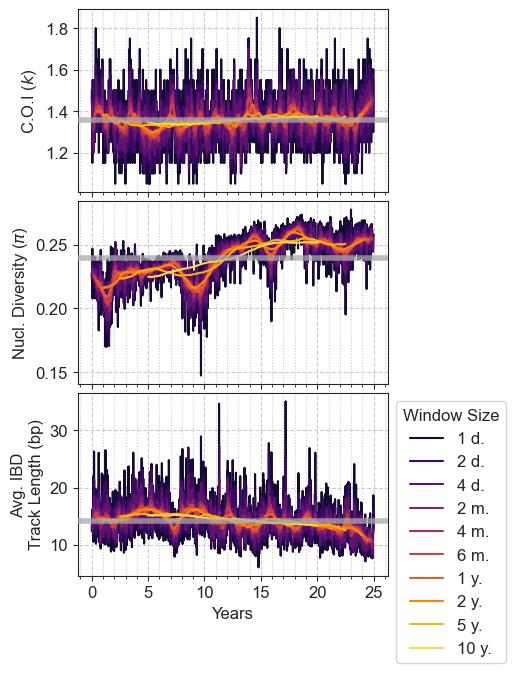

In [51]:
# Preferences
metrics = ["mean_k", "pi", "avg_l_ibd"]
n_metrics = len(metrics)
cols = sns.color_palette("inferno", len(sizes))

# Figure
fig, axes = plt.subplots(n_metrics, 1, figsize=(4, n_metrics*2.5), sharex=True)
fig.subplots_adjust(hspace=0.05)

# By-metric
for ax, metric in zip(axes.flatten(), metrics):
    rolling_plot(metric, sizes, dfs, cols)
    ax.set_ylabel(genetic_names[metric])
    ax.grid(which='minor', linestyle='dotted')
    ax.grid(which='major', linestyle='dashed')

    
# Label, x-axis
ax.set_xlabel("Years", fontsize=12)
    
# Legend
handles = [mpl.lines.Line2D([0], [0], color=col, label=size) 
           for col, size in zip(cols, sizes)]
ax.legend(handles, labs, 
          title="Window Size", bbox_to_anchor=(1, 1))

if savefig:
    fig.savefig("../figs/sec3_rolling-mean-single-%s.pdf" % sim, 
                bbox_inches="tight", pad_inches=0.5)

## Run analysis for *all* simulations

In [18]:
v_dfs = []
for sim in sim_complete:
    # Load full data frame
    epoch_df = pd.read_csv(os.path.join(expt_path, sim, "epoch_df.csv"))
    epoch_df.index = epoch_df.name
    og = pd.read_csv(os.path.join(expt_path, sim, "og.csv"))
    op = pd.read_csv(os.path.join(expt_path, sim, "op.csv"))

    # Merge on time
    ot = pd.merge(left=op, right=og, on="t0")

    # Initial
    initial = subset_to_epoch(ot, epoch_df, "InitVar")[analysis_metrics]
    mu = initial.mean()

    sizes = [1, 5, 10, 25, 50, 100, 250, 500, 750, 1000]
    dfs = []

    for size in sizes:
        df = initial.rolling(size).mean().dropna()
        dfs.append(df)

    vs = []
    for df in dfs:
        v  = ((df - mu)**2).sum() / df.shape[0]
        vs.append(v)

    v_df = pd.concat(vs, 1).transpose()
    v_df["size"] = np.array(sizes) * 5
    
    v_dfs.append(v_df)

In [19]:
result = pd.concat(v_dfs, 0)

mus = result.groupby("size").mean()
stds = result.groupby("size").std()
ses = stds/np.sqrt(len(sim_complete))

### Plot

In [25]:
tight_metric_col_dt.update(dict(zip(["HX", "VX"], sns.color_palette("Greys", 2))))

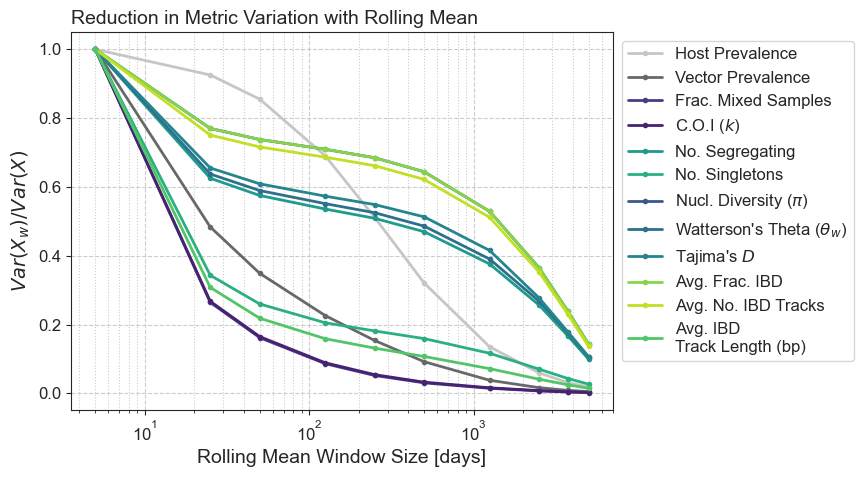

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))


for metric in analysis_metrics:
    ax.plot(mus[metric]/mus[metric].iloc[0], 
            color=tight_metric_col_dt[metric], marker=".",
            linewidth=2,
            label=genetic_names[metric])

ax.set_title("Reduction in Metric Variation with Rolling Mean", loc="left", fontsize=14)
ax.set_xlabel("Rolling Mean Window Size [days]", fontsize=14)
ax.set_ylabel("$Var(X_{w})/Var(X)$", fontsize=14)

ax.set_xscale("log")
ax.legend(bbox_to_anchor=(1, 1))
ax.grid(which='minor', linestyle='dotted')
ax.grid(which='major', linestyle='dashed')

if savefig:
    fig.savefig("../figs/sec3_rolling-mean-all.pdf",
                bbox_inches="tight", pad_inches=0.5)

This is probably good, just want to make a few changes to the colors to clarify the main metrics we are interested in -- plus what about standard error.

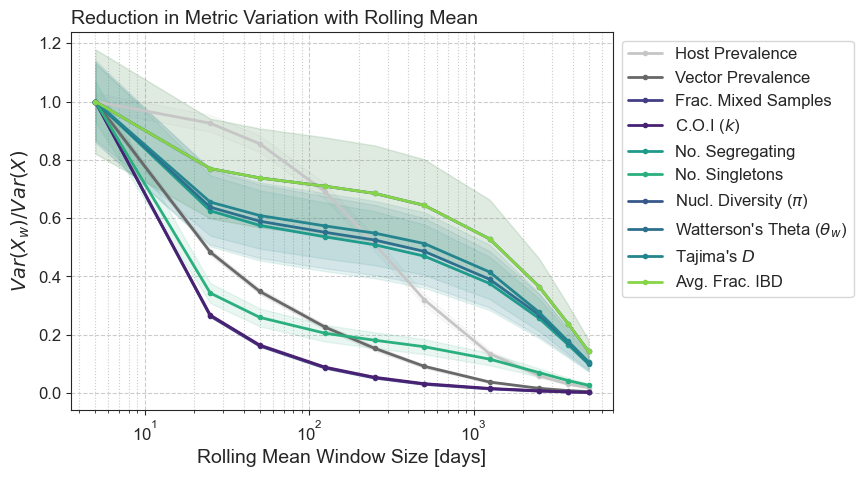

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))


for col, metric in zip(cols, analysis_metrics):
    ax.plot(mus.index,
            mus[metric]/mus[metric].iloc[0], 
            color=tight_metric_col_dt[metric], marker=".",
            linewidth=2,
            label=genetic_names[metric])
    ax.fill_between(x=mus.index,
                    y1=(mus[metric] - 1.96 * ses[metric])/mus[metric].iloc[0],
                    y2=(mus[metric] + 1.96 * ses[metric])/mus[metric].iloc[0],
                    color=tight_metric_col_dt[metric], alpha=0.1)

ax.set_title("Reduction in Metric Variation with Rolling Mean", loc="left", fontsize=14)
ax.set_xlabel("Rolling Mean Window Size [days]", fontsize=14)
ax.set_ylabel("$Var(X_{w})/Var(X)$", fontsize=14)

ax.set_xscale("log")
ax.legend(bbox_to_anchor=(1, 1))
ax.grid(which='minor', linestyle='dotted')
ax.grid(which='major', linestyle='dashed')

if savefig:
    fig.savefig("../figs/sec3_rolling-mean-all-se.pdf",
                bbox_inches="tight", pad_inches=0.5)

### Focus on a few independent metrics

In [31]:
focus_metrics = ["mean_k", "pi", "avg_l_ibd"]

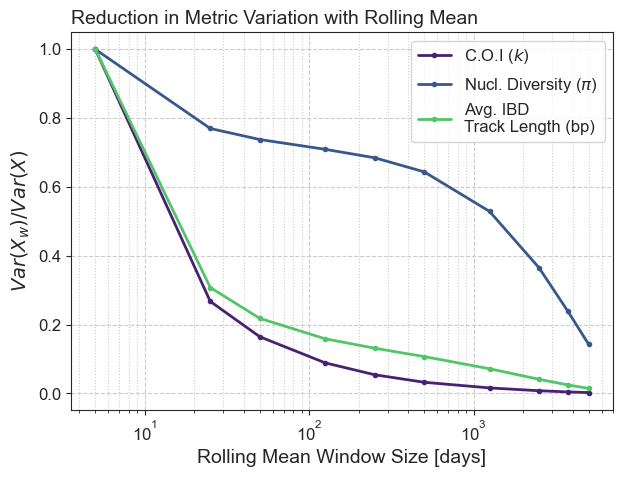

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))


for metric in focus_metrics:
    ax.plot(mus[metric]/mus[metric].iloc[0], 
            color=tight_metric_col_dt[metric], marker=".",
            linewidth=2,
            label=genetic_names[metric])

ax.set_title("Reduction in Metric Variation with Rolling Mean", loc="left", fontsize=14)
ax.set_xlabel("Rolling Mean Window Size [days]", fontsize=14)
ax.set_ylabel("$Var(X_{w})/Var(X)$", fontsize=14)

ax.set_xscale("log")
#ax.legend(bbox_to_anchor=(1, 1))
ax.legend()
ax.grid(which='minor', linestyle='dotted')
ax.grid(which='major', linestyle='dashed')

if savefig:
    fig.savefig("../figs/sec3_rolling-mean-focus.pdf",
                bbox_inches="tight", pad_inches=0.5)